# Effects of different factors on the duration of bike trip

## Investigation Overview

In this investigation, I wanted to know more about the changes in trip duration across different factors. The analysis has been mainly focused on three factors: one numeric variable (distance) and two categorical variables (user type and weekday).

## Dataset Overview

The dataset consists of 519700 trip records from Bay Wheel in 2017. The attributes covered duration of trip, timestamp(start_time and end_time), station(start_station and end_station), bike(bike_id) and user(user_type). It's worth mentioning here that distance and weekday variables were initially not included in the dataset and computed based on values from timestamp and station(longitude and latitude).  


In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

%matplotlib inline

In [3]:
trip = pd.read_csv('2017-fordgobike-tripdata.csv')

In [4]:
# convert datatype from integer to datetime 
trip[['start_time','end_time']] = trip[['start_time','end_time']].apply(pd.to_datetime)

## Distribution of trip durations

Duration in the dataset takes on a very large range of values, from about 61 seconds at the lowest, to about 86400 seconds at the highest. Plotted on a logarithmic scale, the distribution of duration takes on a unimodal shape.

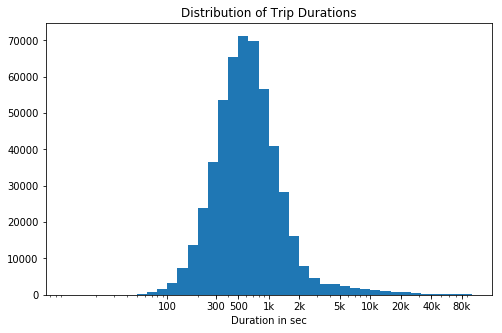

In [6]:
# there's a long tail in the distribution, so I will convert it on a log scale instead
log_binsize = 0.1
bins = 10 ** np.arange(1, np.log10(trip['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.title('Distribution of Trip Durations')
plt.hist(data = trip, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([100, 300, 500, 1e3, 2e3, 5e3, 1e4, 2e4, 4e4, 8e4], [100, 300, 500,'1k', '2k', '5k', '10k', '20k','40k','80k'])
plt.xlabel('Duration in sec')

plt.show()

##  Distribution of weekdays
Distribution of timestamp will be grouped and plotted across months due to the large amount of values (trip records) falling into each point of time (specified in second in original dataset). Observing distribution of months would generate an overview of seasonal trend but not specific enough to deeper analysis. To tackle this issue, weekday variable is created in univariate exploration to represent time dimension. <br>
Weekday variable contains 7 values from Monday to Sunday and is taken as ordinal variable. 

In [7]:
# creat a new column to specify days of week based on start_time
weekdays={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
trip['weekday'] = trip['start_time'].dt.weekday.map(weekdays)

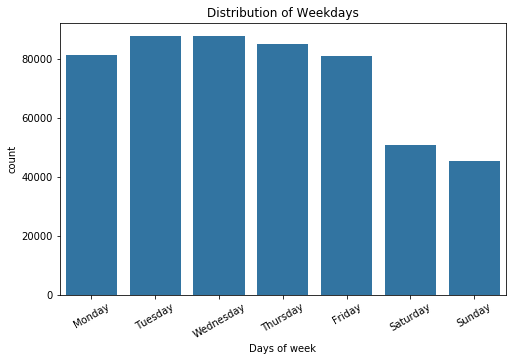

In [13]:
# setup weekday as ordinal variable and plot
weekday_cat = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
order_week = pd.api.types.CategoricalDtype(ordered=True, categories=weekday_cat)
trip['weekday']=trip['weekday'].astype(order_week)

plt.figure(figsize=[8, 5])
plt.title('Distribution of Weekdays')
base_color=sb.color_palette()[0]
ax = sb.countplot(data=trip, x='weekday',color=base_color)
ax.set_xlabel('Days of week')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

plt.show()

## Distribution of user types

There are two types of user in the dataset: casual customer and subsriber.

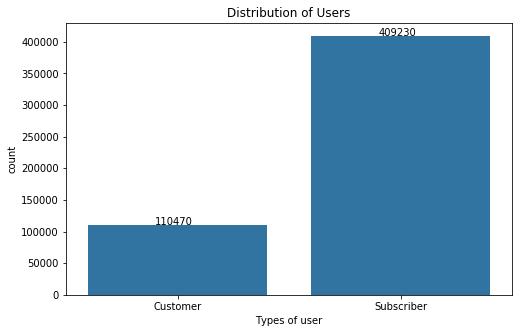

In [14]:
# creat countplot for categorical variable user_type
plt.figure(figsize=[8, 5])
plt.title('Distribution of Users')
ax = sb.countplot(data=trip, x='user_type',color=base_color)
ax.set_xlabel('Types of user')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.3, p.get_height()+4))

## Distribution of distances

As explained at the beginning of this report, the distance variable is calculated based on four variables in original dataset which are: start_station_latitude, start_station_longitude, end_station_latitude and end_station_longitude.
Distance refer to the distance between start-station and end-station, hence the distance of the trip. Unit is kilometer. 

In [15]:
# calculte distance with latitude and longitude input
def distance(lat1, lon1,lat2, lon2):
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d


In [16]:
# use a loop to calculate the distance value for each entry 
ds=[]
for i in range(519700):
    lat1 = trip.start_station_latitude[i]
    lon1 = trip.start_station_longitude[i]
    lat2 = trip.end_station_latitude[i]
    lon2 = trip.end_station_longitude[i]
    ds.append(distance(lat1, lon1,lat2, lon2))

In [17]:
# create a new column to store the value of distance
trip['distance_km'] = ds

(0, 8)

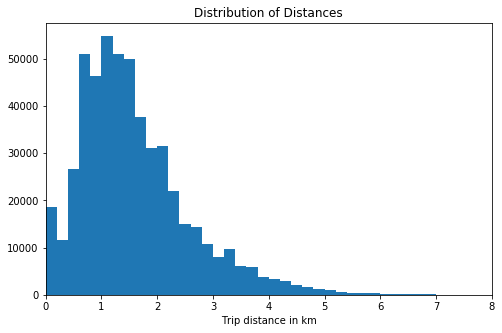

In [20]:
plt.figure(figsize=[8, 5])
plt.title('Distribution of Distances')
bins = np.arange(0,8,0.2)
plt.hist(data=trip, x='distance_km',bins=bins)
plt.xlabel('Trip distance in km')
plt.xlim((0,8)) # set up limitation on x-axis to remove outliers of very large values

## Duration vs Distance
Plotting duration on a logarithmic scale shows a positive correlation distance and duration, especially in the distance range of 0.5km-3.5km, as indicated by regression line. 

In [22]:
# define log transformation function
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)
# create subset to filter out distance value over 10km
distance_outliers = (trip['distance_km'] > 10)
trip_sub = trip.loc[-distance_outliers,:]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


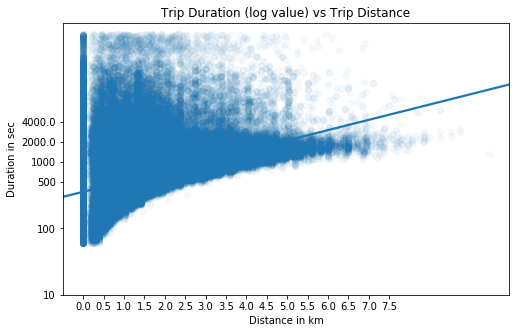

In [23]:
plt.figure(figsize=[8,5])
plt.title('Trip Duration (log value) vs Trip Distance')
sb.regplot(trip_sub['distance_km'], trip_sub['duration_sec'].apply(log_trans),
          scatter_kws={'alpha':1/30})
xticks = np.arange(0,8,0.5)
tick_locs = [10,100,500,1000,2e3,4e3]
plt.yticks(log_trans(tick_locs),tick_locs)
plt.ylabel('Duration in sec')
plt.xlabel('Distance in km')
plt.xticks(xticks, xticks)

plt.show()

## Duration vs  User Type

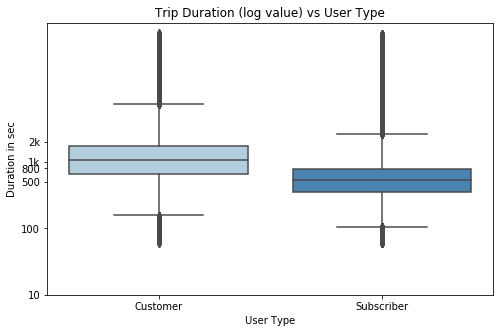

In [24]:
plt.figure(figsize=[8,5])
plt.title('Trip Duration (log value) vs User Type')
g = sb.boxplot(data=trip, x='user_type', y=trip['duration_sec'].apply(log_trans), palette='Blues')
g.set_yticks(log_trans(np.array([10,100,500,800,1000,2e3])))
g.set_yticklabels([10,100, 500, 800,'1k', '2k'])
plt.xlabel('User Type')
plt.ylabel('Duration in sec')


plt.show()

## Duration vs Weekday

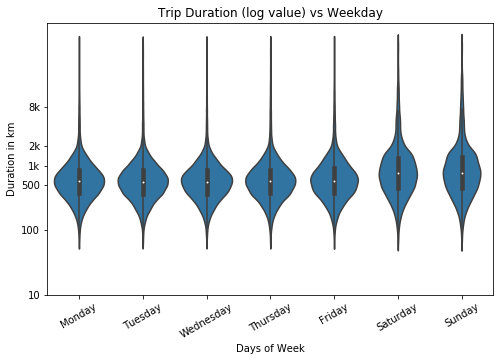

In [25]:
plt.figure(figsize=(8,5))
plt.title('Trip Duration (log value) vs Weekday')
g = sb.violinplot(data=trip, x='weekday', y=trip['duration_sec'].apply(log_trans),color=base_color)
g.set_yticks(log_trans(np.array([10,100,500,1000,2e3,8e3])))
g.set_yticklabels([10,100, 500,'1k', '2k','8k'])
plt.xticks(rotation=30)
plt.xlabel('Days of Week')
plt.ylabel('Duration in km')

plt.show()

## Duration by User Type and Weekday

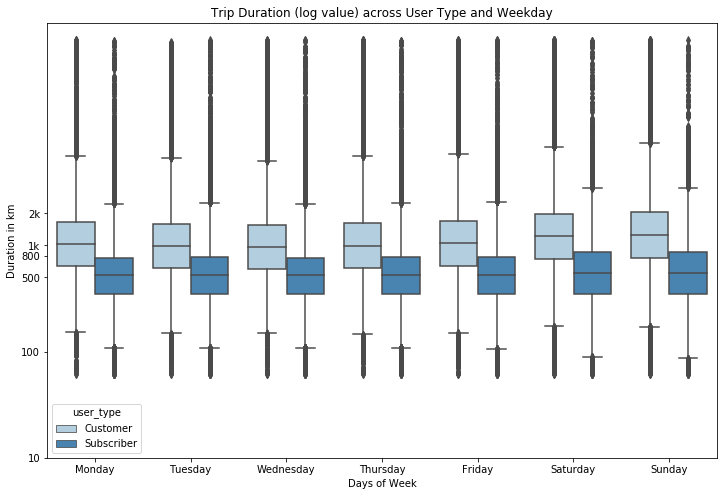

In [27]:
plt.figure(figsize=(12,8))
plt.title('Trip Duration (log value) across User Type and Weekday')
g = sb.boxplot(data=trip, x='weekday', y=trip['duration_sec'].apply(log_trans),hue='user_type',palette='Blues')
g.set_yticks(log_trans(np.array([10,100,500,800,1000,2e3])))
g.set_yticklabels([10,100, 500, 800,'1k', '2k'])
plt.xlabel('Days of Week')
plt.ylabel('Duration in km')

plt.show()

## Selected Duration by User Type and Weekday

In [29]:
# select duration values between 500 and 2000 secs
duration_range = (trip_sub['duration_sec'] >= 500) & (trip_sub['duration_sec'] <= 2000)
trip_1c = trip_sub.loc[duration_range,:]

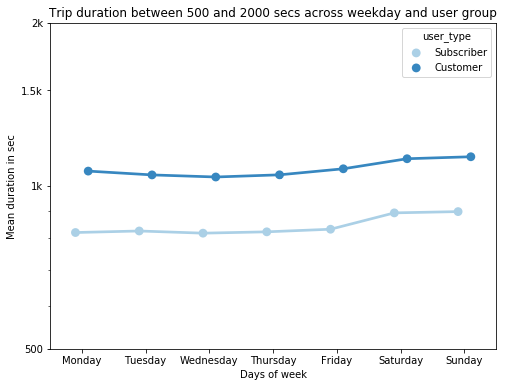

In [30]:
fig = plt.figure(figsize = [8,6])
plt.title('Trip duration between 500 and 2000 secs across weekday and user group')
ax = sb.pointplot(data = trip_1c, x = 'weekday', y = 'duration_sec', hue = 'user_type',
           palette = 'Blues', dodge = 0.2)
plt.xlabel('Days of week')
plt.ylabel('Mean duration in sec')
plt.yscale('log')
plt.yticks([500, 1000, 1500, 2000], [500, '1k', '1.5k', '2k'])
ax.set_yticklabels([],minor = True)

plt.show()

## Selected distance by User Type and Weekday

In [47]:
# select only values in distance under 8km
distance_range = (trip_sub['distance_km'] >= 0) & (trip_sub['distance_km'] <= 8)
trip_dis = trip_sub.loc[distance_range,:]

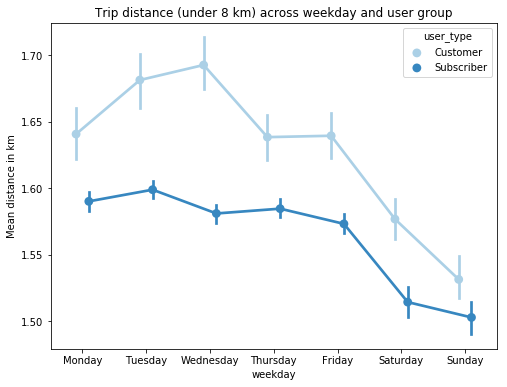

In [49]:
fig = plt.figure(figsize = [8,6])
plt.title('Trip distance (under 8 km) across weekday and user group')
ax = sb.pointplot(data = trip_dis, x = 'weekday', y = 'distance_km', hue = 'user_type',
           palette = 'Blues', dodge = 0.2)
plt.xlabel('Days of Week')
plt.ylabel('Mean distance in km')
ax.set_yticklabels([],minor = True)

plt.show();